In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_d4.jpg
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_b5.jpg
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_ea.jpg
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_a3.jpg
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_9a.jpg
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_98.jpg
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_ee.jpg
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_ca.jpg
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_88.jpg
/kaggle/input/ident

# Loading Dataset

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import io

dataset_dir = '/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset'  

classes = ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']

def load_image_paths_and_labels(dataset_dir, classes):
    image_paths = []
    labels = []
    
    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):  
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(class_name)
    
    return pd.DataFrame({'filepaths': image_paths, 'labels': labels})

In [4]:
df = load_image_paths_and_labels(dataset_dir, classes)

distribution = df['labels'].value_counts()
print("Data distribution for each class:")
print(distribution)

Data distribution for each class:
labels
red leaf spot    143
white spot       142
algal leaf       113
brown blight     113
Anthracnose      100
bird eye spot    100
gray light       100
healthy           74
Name: count, dtype: int64


# Train Test Split

In [3]:
df = load_image_paths_and_labels(dataset_dir, classes)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['labels'])

print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (566, 2)
Validation set: (142, 2)
Test set: (177, 2)


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rescale=1./255)

train = image_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224,224),
    color_mode="rgb",
    class_mode="categorical",  
    batch_size=32,
    shuffle=False  
)


val = image_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224,224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False  
)


test = image_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224,224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False  
)

Found 566 validated image filenames belonging to 8 classes.
Found 142 validated image filenames belonging to 8 classes.
Found 177 validated image filenames belonging to 8 classes.


# Flattening Images

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_flatten_images(df, target_size=(224, 224)):
    images = []
    for filepath in df['filepaths']:
        img = load_img(filepath, target_size=target_size)  
        img_array = img_to_array(img) / 255.0 
        img_flattened = img_array.flatten()  
        images.append(img_flattened)
    return np.array(images)


X_train = load_and_flatten_images(train_df)
X_val = load_and_flatten_images(val_df)
X_test = load_and_flatten_images(test_df)

y_train = train_df['labels'].values
y_val = val_df['labels'].values
y_test = test_df['labels'].values

# Training Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Testing Random Forest

In [30]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_test = rf_classifier.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report on Test Set:\n", classification_report(y_test, y_pred_test))

Test Accuracy: 0.7909604519774012
Classification Report on Test Set:
                precision    recall  f1-score   support

  Anthracnose       0.65      0.75      0.70        20
   algal leaf       0.90      0.86      0.88        22
bird eye spot       0.77      0.50      0.61        20
 brown blight       0.80      0.52      0.63        23
   gray light       0.69      0.90      0.78        20
      healthy       1.00      0.93      0.97        15
red leaf spot       0.90      0.90      0.90        29
   white spot       0.72      0.93      0.81        28

     accuracy                           0.79       177
    macro avg       0.80      0.79      0.78       177
 weighted avg       0.80      0.79      0.78       177



# Confusion Matrix on Random Forest

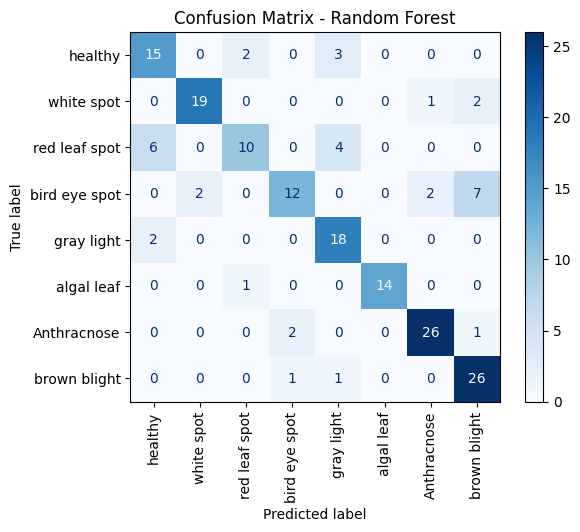

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix_test = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=train_df['labels'].unique())
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)

plt.title("Confusion Matrix - Random Forest")
plt.show()

# Training Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

# Testing Decision Tree

In [26]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_test = dt_classifier.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report on Test Set:\n", classification_report(y_test, y_pred_test))

Test Accuracy: 0.6440677966101694
Classification Report on Test Set:
                precision    recall  f1-score   support

  Anthracnose       0.57      0.40      0.47        20
   algal leaf       0.68      0.59      0.63        22
bird eye spot       0.37      0.35      0.36        20
 brown blight       0.47      0.30      0.37        23
   gray light       0.62      0.90      0.73        20
      healthy       1.00      0.93      0.97        15
red leaf spot       0.79      0.79      0.79        29
   white spot       0.63      0.86      0.73        28

     accuracy                           0.64       177
    macro avg       0.64      0.64      0.63       177
 weighted avg       0.64      0.64      0.63       177



# Confusion Matrix on Decision Tree

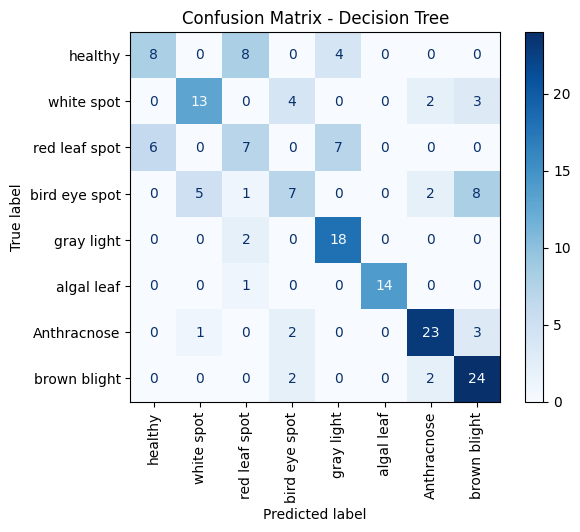

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix_test = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=train_df['labels'].unique())
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=90)

plt.title("Confusion Matrix - Decision Tree")

plt.show()